In [ ]:
pandas
numpy
scipy
statsmodels
sewborn
matplotlib
sklearn
gensim
collections
surprise

In [95]:
import pandas as pd
from pandas import read_csv
import numpy as np

import scipy.stats as spst
from scipy.spatial.distance import pdist, jaccard

from statsmodels.tsa.ar_model import AR

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

%matplotlib inline

from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from gensim.models import doc2vec

from collections import namedtuple
from collections import defaultdict
from collections import Counter

from surprise import KNNWithMeans
from surprise import Dataset,Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

# EDA

In [6]:
us = pd.read_csv("USvideos.csv")

In [90]:
us[us.dislikes/us.likes>1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 43 to 40809
Data columns (total 16 columns):
video_id                  576 non-null object
trending_date             576 non-null object
title                     576 non-null object
channel_title             576 non-null object
category_id               576 non-null int64
publish_time              576 non-null object
tags                      576 non-null object
views                     576 non-null int64
likes                     576 non-null int64
dislikes                  576 non-null int64
comment_count             576 non-null int64
thumbnail_link            576 non-null object
comments_disabled         576 non-null bool
ratings_disabled          576 non-null bool
video_error_or_removed    576 non-null bool
description               517 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 64.7+ KB


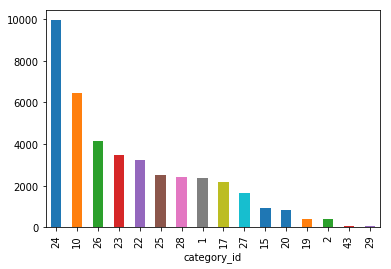

In [134]:
us.groupby(['category_id']).count()['video_id'].sort_values()[::-1].plot(kind='bar')

In [122]:
pd.unique(us.category_id)

array([22, 24, 23, 28,  1, 25, 17, 10, 15, 27, 26,  2, 19, 20, 29, 43])

In [126]:
channels = us[us.category_id==24].groupby("channel_title").count()['video_id'].sort_values()[::-1]

In [147]:
public = us[us.category_id==24].groupby("channel_title").count()['video_id'].sort_values()[::-1].index

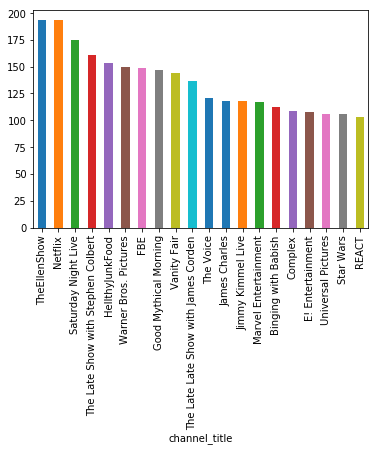

In [127]:
channels[:20].plot("bar")

In [128]:
channels = us[us.category_id==10].groupby("channel_title").count()['video_id'].sort_values()[::-1]

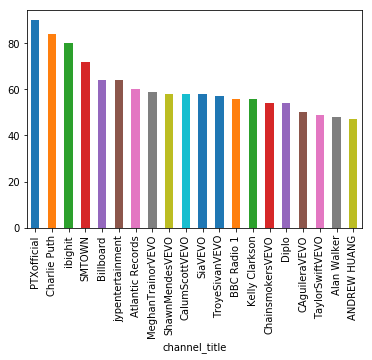

In [129]:
channels[:20].plot("bar")

In [131]:
channels = us[us.category_id==26].groupby("channel_title").count()['video_id'].sort_values()[::-1]

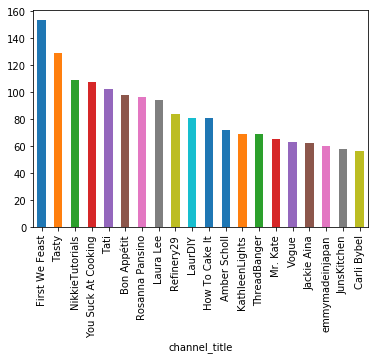

In [132]:
channels[:20].plot("bar")

In [135]:
channels = us[us.category_id==23].groupby("channel_title").count()['video_id'].sort_values()[::-1]

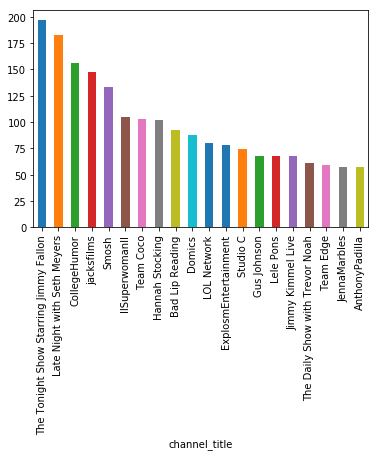

In [136]:
channels[:20].plot("bar")

In [137]:
channels = us[us.category_id==22].groupby("channel_title").count()['video_id'].sort_values()[::-1]

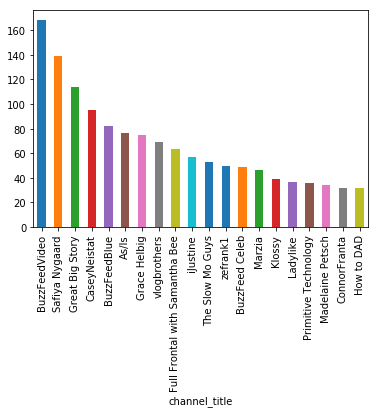

In [138]:
channels[:20].plot("bar")

In [146]:
popular = us.groupby("channel_title").count()['video_id'].sort_values()[::-1][:200].index

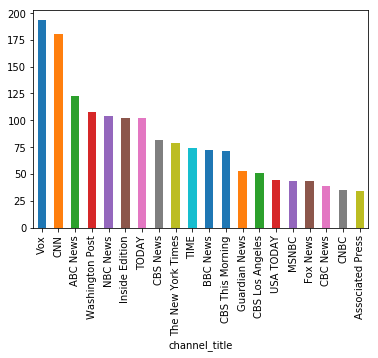

In [149]:
channels = us[us.category_id==25].groupby("channel_title").count()['video_id'].sort_values()[::-1]
channels[:20].plot("bar")

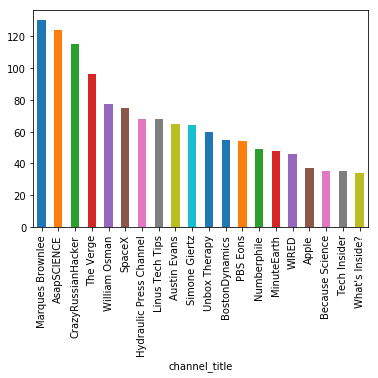

In [151]:
channels = us[us.category_id==28].groupby("channel_title").count()['video_id'].sort_values()[::-1]
channels[:20].plot("bar")

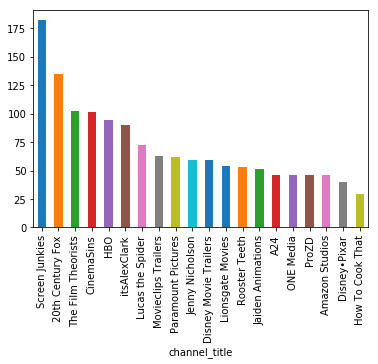

In [153]:
channels = us[us.category_id==1].groupby("channel_title").count()['video_id'].sort_values()[::-1]
channels[:20].plot("bar")

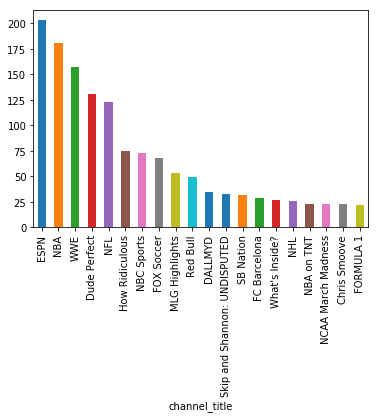

In [154]:
channels = us[us.category_id==17].groupby("channel_title").count()['video_id'].sort_values()[::-1]
channels[:20].plot("bar")

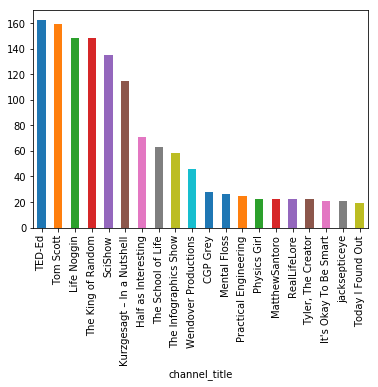

In [155]:
channels = us[us.category_id==27].groupby("channel_title").count()['video_id'].sort_values()[::-1]
channels[:20].plot("bar")

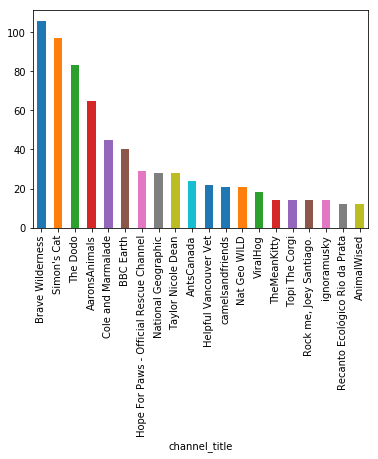

In [156]:
channels = us[us.category_id==15].groupby("channel_title").count()['video_id'].sort_values()[::-1]
channels[:20].plot("bar")

# Feature Engineering

In [48]:
tags = (i.split("|") for i in us.tags)

In [43]:
new_tags = [i for i in tags]

In [45]:
new_tags= [[j.strip('"') for j in i] for i in new_tags]

In [54]:
all_tags = []
for i in new_tags:
    all_tags += i

In [57]:
len(all_tags),len(set(all_tags)) # number of tags and number of unique tags

(808183, 56693)

# Calculate similarity between videos based on tags

##### First approach: distance to int

In [64]:
int2tag = {}
for i,v in enumerate(list(set(all_tags))):
    int2tag[i] = v
tag2int = {v:k for k,v in int2tag.items()}

In [83]:
int_tag = []
for tag in new_tags:
    int_t = []
    for t in tag:
        int_t.append(tag2int[t])
    int_tag.append(sorted(int_t))

In [79]:
int_tag = np.array(int_tag)

In [80]:
int_tag

array([array([19882]), array([50190, 52197, 34353, 46018]),
       array([54427,  3292, 49010, 36886, 54061, 45916, 56207, 41686, 46661,
       51877,  2492, 11123, 31110, 46778, 43605, 16744,   850, 46486,
       48695, 48370, 13762, 34452, 27583]),
       ...,
       array([54100, 35313, 30114,  4597,  8521, 34057, 16462,  1212, 32497,
       16067, 43130, 52919,  3839, 33899, 34124,  2569, 27835, 35964,
       45136, 20262, 53943,  2322, 19881, 26172]),
       array([ 5559,  7609, 44724, 39657,  7157, 44658, 54001, 42875, 29246,
       35862,  9721, 13477, 36722, 29162, 53208, 28638, 46820,  7560,
       12640, 19435, 35481, 25255]),
       array([10071,  6421, 18664, 54626])], dtype=object)

In [88]:
jaccard_matrix = np.zeros((len(int_tag),len(int_tag)))
for i in range(len(int_tag)):
    for j in range(i,len(int_tag)):
        x = set(int_tag[i])
        y = set(int_tag[j])
        z = x.intersection(y)
        jaccard_matrix[i][j] = len(z)/max(len(int_tag[i]),len(int_tag[j]))

KeyboardInterrupt: 

##### doc2vec

In [ ]:
tags = (i.split("|") for i in us.tags)
new_tags = [i for i in tags]
new_tags= [[j.strip('"') for j in i] for i in new_tags]
all_tags = []
for i in new_tags:
    all_tags += i

In [ ]:
doc_vecs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(new_tags):
    words = text
    tags = [i]
    doc_vecs.append(analyzedDocument(words, tags))
# window (int, optional) – The maximum distance between the current and predicted word within a sentence.
# workers (int, optional) – Use these many worker threads to train the model 
model = doc2vec.Doc2Vec(doc_vecs, vector_size = 20, window = 30, min_count = 3, workers = 4)

In [ ]:
dist = pairwise_distances(l, metric = "cosine")
rank = np.argsort(-dist)
rank = rank[:,::-1]
top_10 = rank[:,1:11]
top_10

In [ ]:
np.savetxt("top_10.csv", top_10, delimiter=",")

# Find the similar videos within the same category

In [97]:
df = us[['category_id','channel_title','views']]
items = pd.unique(df.channel_title)

int2item = {}
for i,v in enumerate(list(set(items))):
    int2item[i] = v
item2int = {v:k for k,v in int2item.items()}

int_item = []
for item in df.channel_title:
    int_item.append(item2int[item])
    
df['int_item']=int_item

/Users/roxanne/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [98]:
df = pd.DataFrame({'user': df.category_id, 'hotel': df.int_item, 'raw_rating': df.views})

reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(df,reader)
trainset, testset = train_test_split(data, test_size=.15)

# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

# run the trained model against the testset
test_pred = algo.test(testset)

# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

# if you wanted to evaluate on the trainset
print("Item-based Model : Training Set")
train_pred = algo.test(trainset.build_testset())
accuracy.rmse(train_pred)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Item-based Model : Test Set
RMSE: 7281776.1506
Item-based Model : Training Set
RMSE: 7843421.9574


7843421.957395101

In [100]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the dataset.
data = Dataset.load_from_df(df,reader)
trainset = data.build_full_trainset()
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

user, recom, user_d = [], [], {}
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    user.append(uid)
    recom.append([iid for (iid, _) in user_ratings])
    user_d[uid]=[iid for (iid, _) in user_ratings]

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [101]:
top_choice=[i[:10] for i in recom]
res_df = pd.DataFrame.from_dict({"user":user,"recom":top_choice})
res_df

,user,recom
0,22,"[1667, 2121, 610, 1598, 235, 822, 1754, 983, 1..."
1,24,"[1898, 2121, 651, 1754, 983, 1686, 856, 224, 1..."
2,23,"[1898, 1667, 610, 1598, 651, 235, 822, 1754, 9..."
3,28,"[1898, 1667, 2121, 610, 1598, 235, 1754, 983, ..."
4,1,"[1898, 2121, 610, 1598, 235, 983, 1686, 2075, ..."
5,25,"[1898, 1667, 2121, 610, 1598, 651, 235, 822, 1..."
6,17,"[1898, 1667, 2121, 610, 1598, 651, 235, 822, 1..."
7,10,"[1898, 1667, 610, 1598, 651, 235, 822, 1754, 9..."
8,15,"[1898, 1667, 2121, 610, 1598, 651, 235, 822, 1..."
9,27,"[1898, 1667, 2121, 610, 1598, 651, 235, 822, 1..."


# Time Series Prediction on category

In [102]:
df = us[us.category_id==1]
res = df.groupby(['trending_date']).sum()['views']

In [108]:
len(res.values),len(X)

(205, 205)

##### Aggregated number of views

Test MSE: 1779354530102490.250


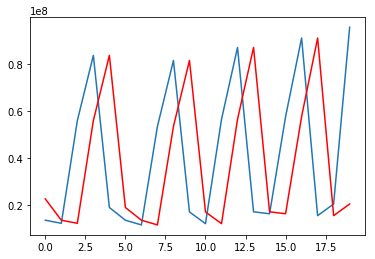

In [110]:
series = res
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-20], X[len(X)-20:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)

print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=35203809.701120, expected=13540976.000000
predicted=22764660.952603, expected=12237922.000000
predicted=40714833.538765, expected=55811457.000000
predicted=66551667.671835, expected=83547629.000000
predicted=35852367.698970, expected=18947907.000000
predicted=33505006.771050, expected=13549774.000000
predicted=28987975.867515, expected=11548805.000000
predicted=40889753.838704, expected=53362260.000000
predicted=61113648.866984, expected=81391027.000000
predicted=31038149.379621, expected=17061799.000000
predicted=33085455.579830, expected=12079595.000000
predicted=30757810.625717, expected=56387541.000000
predicted=25183053.101231, expected=86908590.000000
predicted=43233636.320847, expected=17111011.000000
predicted=48057554.138029, expected=16291423.000000
predicted=29698128.538583, expected=57524763.000000
predicted=29227252.736835, expected=90922579.000000
predicted=57272642.220951, expected=15490426.000000
predicted=58659699.534507, expected=20427064.000000
predicted=64

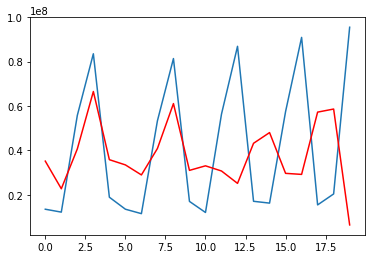

In [109]:
# train test split
series = res
X = series.values
train, test = X[1:len(X)-20], X[len(X)-20:]

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

##### Predict number of videos of each category in trending days

In [114]:
df = us[us.category_id==1]
res = df.groupby(['trending_date']).count()['video_id']

predicted=10.779973, expected=9.000000
predicted=10.349011, expected=7.000000
predicted=10.359837, expected=11.000000
predicted=10.704273, expected=11.000000
predicted=11.522250, expected=11.000000
predicted=10.871884, expected=12.000000
predicted=9.316713, expected=7.000000
predicted=10.695818, expected=10.000000
predicted=10.348496, expected=13.000000
predicted=11.725470, expected=10.000000
predicted=11.673552, expected=6.000000
predicted=10.301193, expected=10.000000
predicted=9.712612, expected=13.000000
predicted=11.549576, expected=10.000000
predicted=11.616909, expected=8.000000
predicted=9.742402, expected=12.000000
predicted=9.061501, expected=13.000000
predicted=12.286700, expected=10.000000
predicted=11.287969, expected=9.000000
predicted=9.409167, expected=13.000000
Test MSE: 6.741


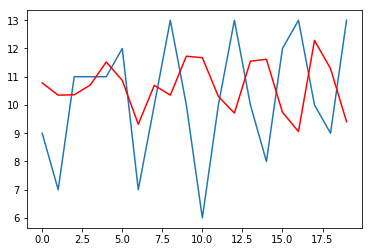

In [115]:
# train test split
series = res
X = series.values
train, test = X[1:len(X)-20], X[len(X)-20:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()